# Séance 3 (Rappel): Apprentissage supervisé

Pour cette dernière séance, on va utiliser toujours le même corpus pour faire cette fois de l'apprentissage supervisé. On s'interessera à de la classification binaire et multi-classe, mais pas à de la classification multi-label (un exemple n'aura qu'une seule classe associée).

Pour chaque approche, vous pouvez considérer comme représentation des articles soit la version brute tf-idf, soit la décomposition par ACP, soit celle par NMF. Attention cependant, si vous faites une ACP ou une NMF, celle-ci doit être apprise uniquement sur l'ensemble d'apprentissage, pas sur celui de test (puis ensuite utilisé sur l'ensemble test). 

Vous pouvez reprendre le code de la séance précédente pour charger et traiter les données.

## Classification binaire

Pour toute cette partie, choisir un couple de labels appartenant à la même catégorie générale (par exemple cs), et un couple de labels de différente catégorie. Chaque couple nous procure un problème de classification binaire. Consistuer vos 2 jeux de données en fonction des labels choisis. 

(Préambule) **Exercice numpy** : dans un premier temps, coder une classe Perceptron avec une méthode fit(X,Y) qui permet d'apprendre le modèle avec une hinge-loss en mini-batche, et une méthode predict(X) pour scorer les données. Tester votre fonction. 

Tester la performance de quelques algorithmes usuels de classification : SVM, forêt aléaoitre, k-plus proches voisins et votre perceptron. Tracer les courbes d'erreur en apprentissage et en test en fonction des hyperparamètres. Comparer les résultats entre tf-idf, ACP et NMF. 
En considérant une des deux classes positives et l'autre négative, on aimerait tracer une courbe ROC des classifieurs. Pour cela, nous avons besoin d'un score de positivité (ou d'une probabilité) plutôt que d'une décision binaire. Pour quel(s) algo(s) est-il possible d'obtenir un tel score ? Tracer les courbes ROCs pour ces algos. 


In [1]:
import json
from datetime import datetime
import re, string
import sklearn
import numpy as np
from scipy.sparse import csr_matrix,lil_matrix
import gzip

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/yass/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yass/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/yass/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
FILENAME = "arxiv-2010-2017.json.gz"

def read_arxiv(f=FILENAME):
    """ lit le fichier arxiv.json """
    res = dict()
    with  open(f) as fp:
        for l in fp:
            js = json.loads(l)
            res[js["id"]] = js
    return res

def build_labels(dic,labels2id=None,id2labels=None,pref=None):
    """ construit la matrice des labels associée à dic
        renvoie la matrice, le dictionnaire de correspondance entre label et index, et le dictionnaire inverse
        ne conserve que les labels commencant par pref.
    """
    if pref is None: pref =""
    if labels2id is None:
        labels = set()
        for k in dic.values():
            labels.update([l for l in k["categories"].split(" ") if l.startswith(pref)])
        labels2id = dict(zip(sorted(labels),range(len(labels))))
        id2labels = dict(zip(range(len(labels)),sorted(labels)))
    labs = lil_matrix((len(dic),len(labels2id)))
    for i,k in enumerate(dic.values()):
        for l in k["categories"].split(" "):
            if l.startswith(pref):
                labs[i,labels2id[l]] = 1.
    return labs,labels2id, id2labels

def get_dates(dic):
    return [datetime.strptime(x["created"],"%a, %d %b %Y %H:%M:%S GMT") for k in dic.values() for x in k["versions"] if x['version']=="v1"]

def sample_corpus(dic,year=2020,categ=""):
    """ filtre le corpus en enlevant les articles sans DOI et ne gardant que les articles de computer science et de date de publication < year"""
    dates = get_dates(dic)
    return dict([d for (d,y) in zip(dic.items(),dates) if d[1]['doi'] is not None and  sum([dd.startswith(categ) for dd in d[1]['categories'].split(" ")]) ==1  and y.year<year])

def get_titles(dic):
    return [k["title"] for k in dic.values()]
def get_abstracts(dic):
    return [k["abstract"] for k in dic.values()]


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(re.sub('[\W_]+',' ',doc.lower()))]
   


In [70]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),lowercase=True,max_features=100000,min_df=0.01)
tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(),lowercase=True,max_features=100000,min_df=0.01)
dataraw = read_arxiv(FILENAME)

In [72]:
# Categorie PL

data_ai = sample_corpus(dataraw, categ="cs.AI")
x_ai = tfidf.fit_transform(get_abstracts(data_ai))
x_ai = x_ai.toarray()

labels_ai = np.full((x_ai.shape[0]), 1)

# Categorie RO

data_pl = sample_corpus(dataraw, categ="cs.PL")
x_pl = tfidf.fit_transform(get_abstracts(data_pl))
x_pl = x_pl.toarray()

labels_pl = np.full((x_pl.shape[0]), -1)

In [74]:
print("Nombre de MATH ::",x_ai.shape[0])
print("Nombre de CS ::",x_pl.shape[0])

Nombre de MATH :: 1460
Nombre de CS :: 824


In [75]:
print("Nombre attributs MATH ::",x_ai.shape[1])
print("Nombre attributs CS ::",x_pl.shape[1])

Nombre attributs MATH :: 1543
Nombre attributs CS :: 1330


In [117]:
# Réduction de composantes
from sklearn import decomposition

nc = 10

pca = decomposition.PCA(n_components= nc)
pca.fit(x_ai)
x_ai_pca = pca.transform(x_ai)

pca = decomposition.PCA(n_components= nc)
pca.fit(x_pl)
x_pl_pca = pca.transform(x_pl)

## Perceptron

In [118]:
# definition cout et gradient

class Perceptron:
    def __init__(self,alpha):
        self.alpha = alpha

   
    def hinge(self,datax, datay, w, alpha=0):
        datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1,1)
        return np.mean(np.maximum(0, alpha-datay*datax.dot(w.T)))

    def hinge_g(self,datax, datay, w, alpha=0):
        datax, datay = datax.reshape(len(datay), -1), datay.reshape(-1,1)
        return -np.mean((((alpha-datay*datax.dot(w.T))>=0)*datax*datay),0)


    def fit(self,datax,datay, maxiter=500):
        self.w = np.random.random((1,datax.shape[1]))
        for i in range(maxiter):
            for i in range(len(datay)):
                self.w = self.w - self.alpha*self.hinge_g(datax[i].reshape(1,-1), datay[i].reshape(1,-1), self.w)
        return datax
   
    def score(self,datax,datay):
        N = len(datax)
        pred = self.predict(datax)
        pred = pred.reshape(pred.shape[0],)
        acc = len(np.where(pred == datay)[0])
        return acc/N
   
    def predict(self,datax):
        if len(datax.shape) == 1:
            datax = datax.reshape(1,-1)
        pred = np.dot(datax, self.w.T)
        return np.sign(pred)


In [119]:
# split des données 
from sklearn.model_selection import train_test_split

datax = np.concatenate((x_ai_pca, x_pl_pca))
datay = np.concatenate((labels_ai, labels_pl))

X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=0.20, shuffle=True)
perc = Perceptron(alpha=1)
perc.fit(X_train, y_train)

array([[-0.12352623,  0.38816184,  0.16338234, ...,  0.01517366,
        -0.1234126 , -0.0651069 ],
       [-0.0355537 , -0.06242458, -0.04289593, ..., -0.05293296,
        -0.00528855, -0.06791483],
       [ 0.01675671,  0.03467229,  0.17491575, ..., -0.0385146 ,
         0.17895001, -0.05837542],
       ...,
       [-0.13240163,  0.31196536, -0.09593206, ...,  0.05246083,
         0.00546241,  0.04014951],
       [-0.05522377, -0.0048089 ,  0.04463765, ...,  0.01712046,
        -0.00563837, -0.07624746],
       [-0.02290657, -0.07134255,  0.02021329, ...,  0.00618088,
        -0.11485293, -0.08444479]])

In [120]:
s = perc.score(X_test,y_test)
print(s)

0.4814004376367615


## SVM

In [121]:
# split des données 
from sklearn.model_selection import train_test_split

datax = np.concatenate((x_ai_pca, x_pl_pca))
datay = np.concatenate((labels_ai, labels_pl))

X_train, X_test, y_train, y_test = train_test_split(datax, datay, test_size=0.20, shuffle=True)
perc = Perceptron(alpha=1)
perc.fit(X_train, y_train)

array([[ 0.28909474, -0.00863816, -0.01951527, ...,  0.00542815,
        -0.05670108, -0.02951021],
       [-0.03502573,  0.04140836,  0.11311105, ..., -0.05961793,
        -0.00422062,  0.03904589],
       [-0.01791398, -0.11527232, -0.00209402, ..., -0.03766824,
         0.0844382 , -0.03095575],
       ...,
       [-0.01547155, -0.07118617,  0.05791411, ...,  0.0394838 ,
         0.07366783,  0.06657198],
       [ 0.48198365,  0.10829004,  0.05279878, ...,  0.02622701,
         0.01973501, -0.00476288],
       [-0.06725048,  0.0069319 ,  0.01134272, ..., -0.11325982,
        -0.04226194, -0.04951591]])

In [122]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
s = clf.score(X_test, y_test)
print(s)

0.8862144420131292


## Perceptron

In [123]:
from sklearn.linear_model import Perceptron

clf = Perceptron(tol=1e-3, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5164113785557987

## Random Forest

In [124]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.6586433260393874

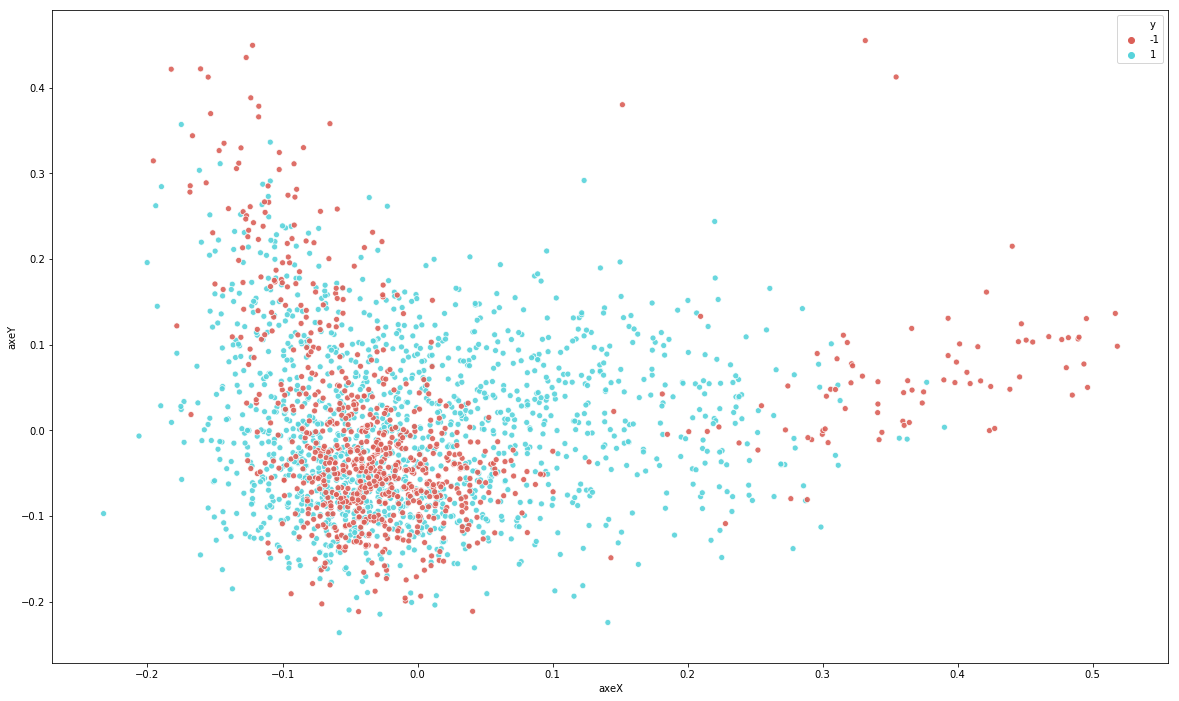

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_tsne = pd.DataFrame()

df_tsne['y'] = datay
df_tsne['axeX'] = datax[:,0]
df_tsne['axeY'] = datax[:,1]

plt.figure(figsize=(20,12))
sns.scatterplot(
    x="axeX", y="axeY",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    legend="full",
    alpha=0.9
)

# Classification multi-classe

Comment peut-on faire de la classification multi-classe en utilisant des algorithmes de classification binaire ? Certains sont-ils adaptables directement ? 

Refaire les mêmes expériences que ci-dessus mais dans une configuration multi-classe, en étudiant le problème pour 5 classes, puis 10 classes que vous choisirez et enfin toutes les classes d'une catégorie générique (type cs). Représenter la matrice de confusion.  
